# AdventureWorks Sales Analysis
## Introduction

In this analysis I examine the AdventureWorks database to answer business questions such as:
- Product categories and their sales
- Sales trends over time
- Regional sales

I use SQL to retrieve data and Python for visualization and analysis. Aggregations on large fact tables (sales, orders) are performed in SQL for performance and clarity, while pandas is used for reshaping (pivoting), scaling, and visualization preparation.

Workflow used in every section:
1. Write a SQL query
2. Load to a pandas DataFrame
3. Plot the result
4. Write a short, decision-focused insight

The analysis is structured to first describe sales performance, then explain drivers (products, regions, customers), and finally evaluate profitability.

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

import pandas as pd

from src.db import read_sql
from src.plot import (
    bar_vertical,
    bar_horizontal,
    line_plot_monthly,
    grouped_bar_wide,
    scatter_plot,
    insight_monthly_trend,
)

## 1) How many products exist in each product category?

**Method:** Join category → subcategory → product and count distinct products per category.

In [2]:
sql_01 = """
SELECT
    pc.Name AS Category,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc
    ON psc.ProductCategoryID = pc.ProductCategoryID
JOIN Production.Product p
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC;
"""

df01 = read_sql(sql_01)
df01

c:\Users\elzah\OneDrive\Sweden\EC Utbildning\SQL\Inlamningsuppgift\adventure-works-sales-analysis\.venv\Lib\site-packages\pandas\io\sql.py:1648: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  con = self.exit_stack.enter_context(con.connect())


,Category,ProductCount
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


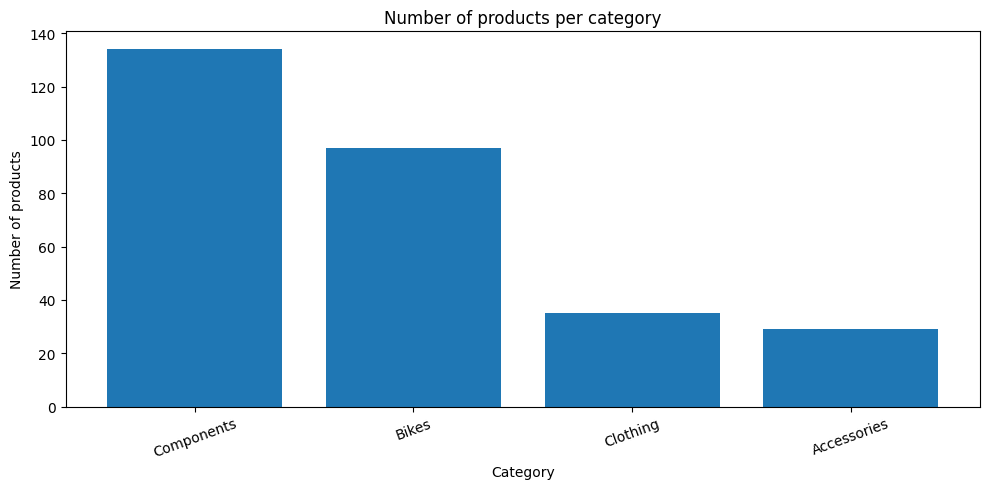

In [3]:
bar_vertical(
    df01,
    x="Category",
    y="ProductCount",
    title="Number of products per category",
    rotate_x=20,
    sort_by="ProductCount",
    ascending=False,
    ylabel="Number of products"
)

In [4]:
most = df01.iloc[0]
least = df01.iloc[-1]
print(f"Most products: {most['Category']} ({int(most['ProductCount'])}). ")
print(f"Least products: {least['Category']} ({int(least['ProductCount'])}).")

Most products: Components (134). 
Least products: Accessories (29).


This visualization shows the number of distinct products within each product category. The Bikes category contains the highest number of products, while Accessories has the fewest. This indicates that the product portfolio is unevenly distributed, with a strong concentration of products in certain categories. A larger assortment may reflect higher strategic importance but can also increase complexity in inventory and product management.

## 2) Which product categories generate the most revenue?

**Method:** Compute revenue from `Sales.SalesOrderDetail` and roll it up to product category.

In [5]:
sql_02 = """
SELECT
    pc.Name AS Category,
    SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON p.ProductID = sod.ProductID
JOIN Production.ProductSubcategory psc
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Production.ProductCategory pc
    ON pc.ProductCategoryID = psc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""

df02 = read_sql(sql_02)
df02["TotalSales"] = df02["TotalSales"].round(2)
df02

,Category,TotalSales
0,Bikes,94651172.72
1,Components,11802593.29
2,Clothing,2120542.53
3,Accessories,1272072.89


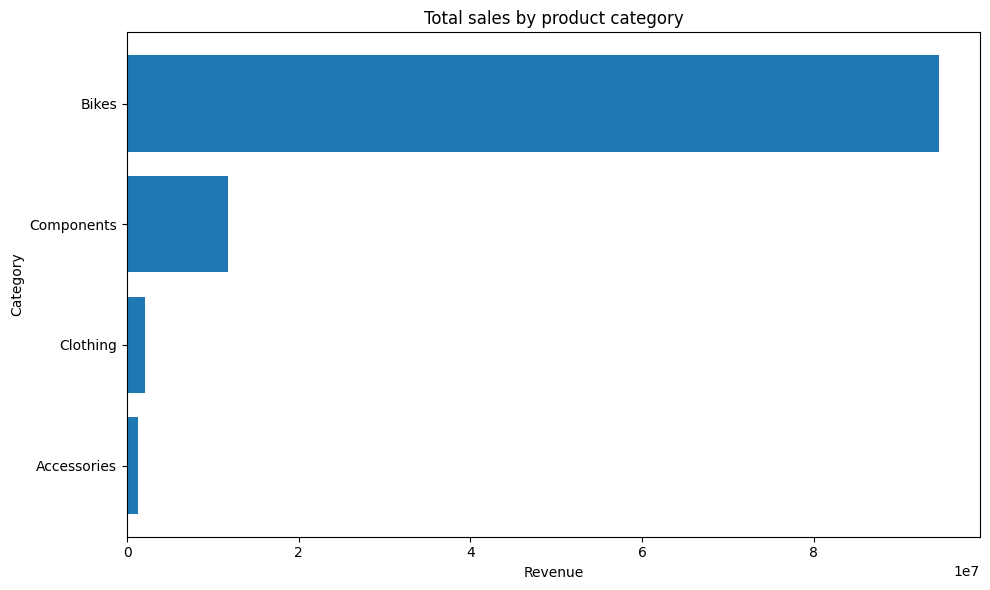

In [6]:
bar_horizontal(
    df02,
    x="TotalSales",
    y="Category",
    title="Total sales by product category",
    xlabel="Revenue",
    ylabel="Category"
)

In [7]:
top = df02.iloc[0]
bottom = df02.iloc[-1]
print(f"Top category: {top['Category']} ({top['TotalSales']:,.2f})")
print(f"Lowest category: {bottom['Category']} ({bottom['TotalSales']:,.2f})")

Top category: Bikes (94,651,172.72)
Lowest category: Accessories (1,272,072.89)


The chart displays total revenue generated by each product category, sorted from highest to lowest. The Bikes category clearly dominates total sales, contributing the majority of overall revenue, while categories such as Accessories generate significantly lower sales. This suggests that company revenue is highly dependent on a small number of core categories, increasing both focus and risk concentration.

## 3) How has total sales developed over time?

**Method:** Aggregate `Sales.SalesOrderHeader.TotalDue` per calendar month.

> I exclude the **latest month** because it can be incomplete and distort the trend.

In [8]:
sql_03 = """
WITH MonthlySales AS (
    SELECT
        DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS MonthStart,
        SUM(TotalDue) AS TotalSales
    FROM Sales.SalesOrderHeader
    GROUP BY DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1)
)
SELECT
    MonthStart,
    TotalSales
FROM MonthlySales
WHERE MonthStart < (SELECT MAX(MonthStart) FROM MonthlySales)
ORDER BY MonthStart ASC;
"""

df03 = read_sql(sql_03)
df03["TotalSales"] = df03["TotalSales"].round(2)
df03.head()

,MonthStart,TotalSales
0,2022-05-01,582415.28
1,2022-06-01,2244313.14
2,2022-07-01,1868508.36
3,2022-08-01,1483277.04
4,2022-09-01,3183714.32


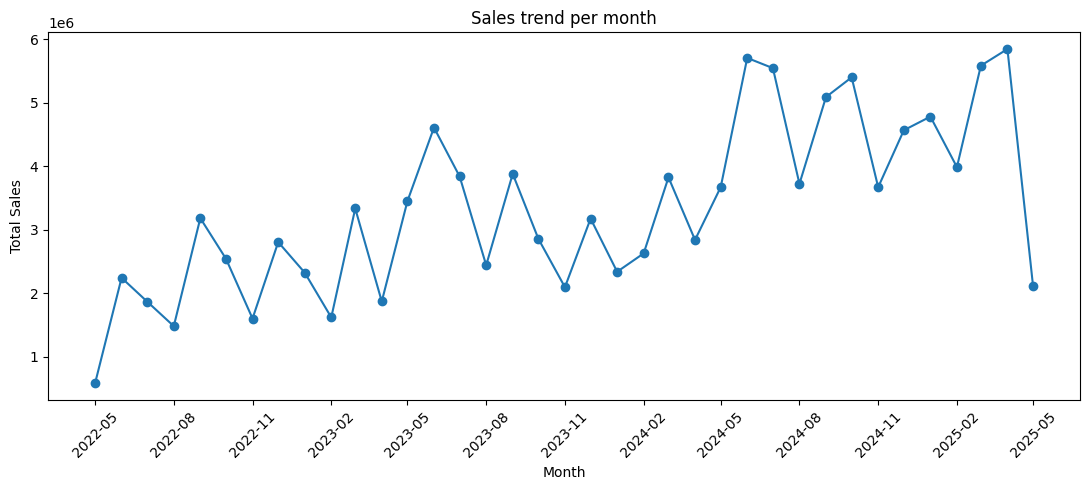

In [9]:
line_plot_monthly(
    df03,
    date_col="MonthStart",
    value_col="TotalSales",
    title="Sales trend per month",
    ylabel="Total Sales",
    month_interval=3,
    marker="o",
)

In [10]:
insight_monthly_trend(df03, date_col='MonthStart', value_col='TotalSales')

**Insight:** The overall monthly sales trend is **upward** from **2022-05** (582,415) to **2025-05** (2,108,406).  
- **Highest month:** **2025-04** (5,847,165)  
- **Lowest month:** **2022-05** (582,415)

This line chart illustrates how total sales have developed on a monthly basis over time. The visualization shows a clear upward trend, indicating overall business growth, with noticeable fluctuations that suggest seasonality. Certain months consistently reach higher sales peaks, while others represent low points, highlighting opportunities for demand forecasting and seasonal planning.

## 4) How do total sales and number of orders compare per year?

**Method:** Aggregate per year from `Sales.SalesOrderHeader`.

> To avoid misleading comparisons, this chart keeps **full years only** (12 months of data).

In [11]:
sql_04 = """
WITH YearAgg AS (
    SELECT
        YEAR(OrderDate) AS OrderYear,
        SUM(TotalDue) AS TotalSales,
        COUNT(*) AS OrderCount,
        COUNT(DISTINCT MONTH(OrderDate)) AS MonthsInYear
    FROM Sales.SalesOrderHeader
    GROUP BY YEAR(OrderDate)
)
SELECT
    OrderYear,
    TotalSales,
    OrderCount
FROM YearAgg
WHERE MonthsInYear = 12
ORDER BY OrderYear;
"""

df04 = read_sql(sql_04)
df04["OrderYear"] = df04["OrderYear"].astype(int)
df04["TotalSales"] = df04["TotalSales"].round(2)

df04["TotalSales_M"] = (df04["TotalSales"] / 1e6).round(2)
df04["OrderCount_K"] = (df04["OrderCount"] / 1e3).round(2)
df04

,OrderYear,TotalSales,OrderCount,TotalSales_M,OrderCount_K
0,2023,35514705.67,3830,35.51,3.83
1,2024,49020486.51,14244,49.02,14.24


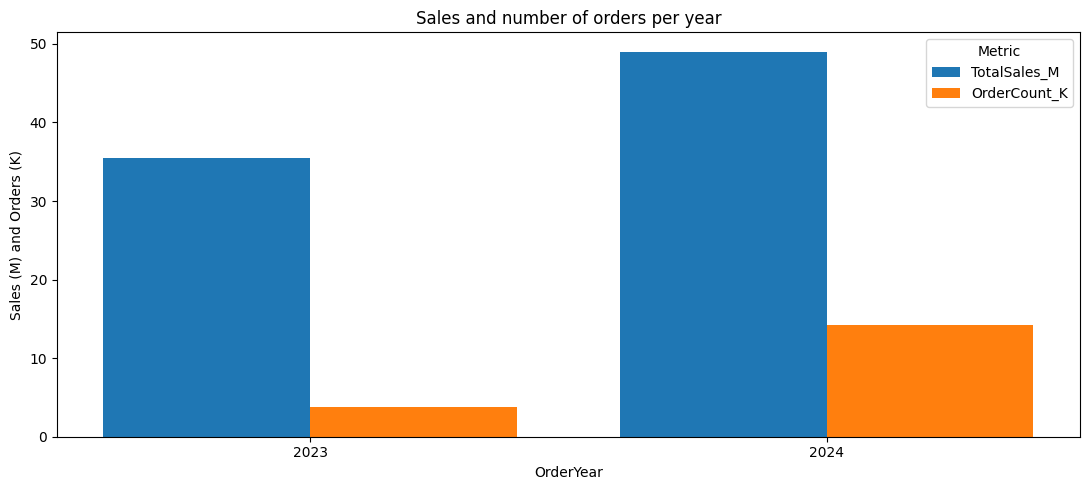

In [12]:
grouped_bar_wide(
    df04,
    x="OrderYear",
    y_cols=["TotalSales_M", "OrderCount_K"],
    title="Sales and number of orders per year",
    ylabel="Sales (M) and Orders (K)",
    legend_title="Metric",
)

In [13]:
best_year = df04.loc[df04["TotalSales"].idxmax(), "OrderYear"]
print(f"Highest sales year (full years only): {best_year}")

Highest sales year (full years only): 2024


This visualization compares total sales and total order volume across complete calendar years. While both metrics generally increase over time, the growth rate of sales exceeds the growth in order count. This suggests that average order value has increased, meaning revenue growth is driven not only by more orders but also by higher value per order.

## 5) Which 10 products generate the most revenue?

**Method:** Revenue per product from `Sales.SalesOrderDetail` joined to `Production.Product`.

In [14]:
sql_05 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

df05 = read_sql(sql_05)
df05["TotalSales"] = df05["TotalSales"].round(2)
df05

,ProductName,TotalSales
0,"Mountain-200 Black, 38",4400592.80
1,"Mountain-200 Black, 42",4009494.76
2,"Mountain-200 Silver, 38",3693678.03
3,"Mountain-200 Silver, 42",3438478.86
4,"Mountain-200 Silver, 46",3434256.94
5,"Mountain-200 Black, 46",3309673.22
6,"Road-250 Black, 44",2516857.31
7,"Road-250 Black, 48",2347655.95
8,"Road-250 Black, 52",2012447.78
9,"Road-150 Red, 56",1847818.63


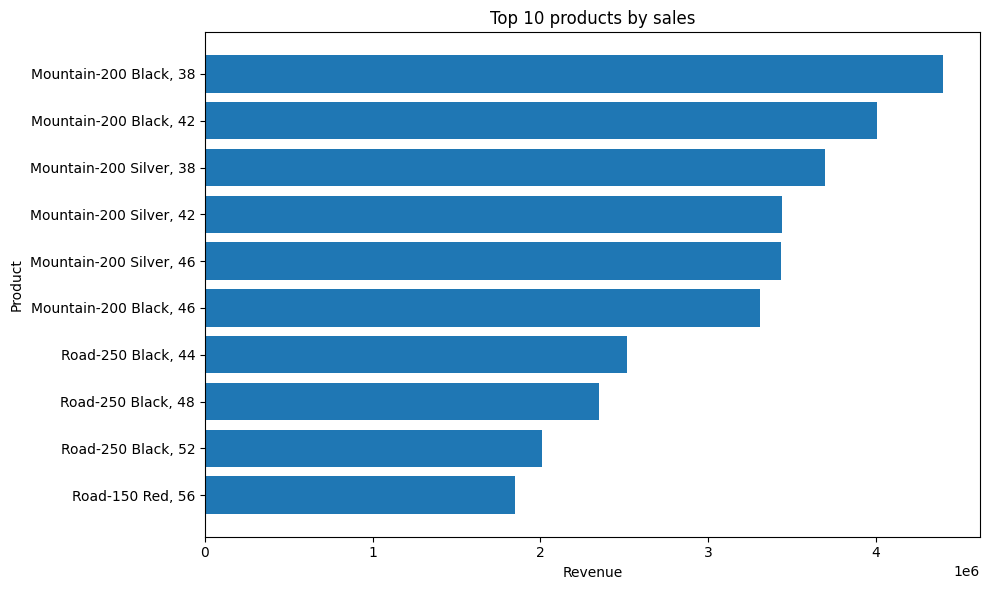

In [15]:
bar_horizontal(
    df05,
    x="TotalSales",
    y="ProductName",
    title="Top 10 products by sales",
    xlabel="Revenue",
    ylabel="Product",
)

In [16]:
top1 = df05.iloc[0]
print(f"#1 product: {top1['ProductName']} ({top1['TotalSales']:,.2f})")

#1 product: Mountain-200 Black, 38 (4,400,592.80)


The chart displays the ten products with the highest total sales revenue, sorted from highest to lowest. The top-performing product is **Mountain-200 Black, 38**, which generates **$4,400,592.80** in total sales, making it the single largest revenue contributor among all products.

The top 10 list is clearly dominated by products from the **Mountain Bikes** category. Multiple variants of the *Mountain-200* model (across different colors and sizes) appear in the ranking, indicating that this category drives a substantial share of overall sales. This suggests strong and consistent customer demand for high-end mountain bikes compared to other product categories.

## 6) How does sales differ by region, and how many unique customers does each region have?

**Method:** Join territory → order header → customer and aggregate.

In [17]:
sql_06 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.CustomerID) AS UniqueCustomers
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st
    ON st.TerritoryID = soh.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df06 = read_sql(sql_06)

df06["TotalSales"] = df06["TotalSales"].astype(float)
df06["UniqueCustomers"] = df06["UniqueCustomers"].astype(int)

df06["SalesPerCustomer"] = (df06["TotalSales"] / df06["UniqueCustomers"]).round(2)

df06.style.format({
    "TotalSales": "{:,.2f}",
    "UniqueCustomers": "{:,}",
    "SalesPerCustomer": "{:,.2f}"
})

,Region,TotalSales,UniqueCustomers,SalesPerCustomer
0,Southwest,"27,150,594.59","4,565","5,947.56"
1,Canada,"18,398,929.19","1,677","10,971.34"
2,Northwest,"18,061,660.37","3,428","5,268.86"
3,Australia,"11,814,376.10","3,625","3,259.14"
4,Central,"8,913,299.25",69,"129,178.25"
5,Southeast,"8,884,099.37",91,"97,627.47"
6,United Kingdom,"8,574,048.71","1,951","4,394.69"
7,France,"8,119,749.35","1,844","4,403.33"
8,Northeast,"7,820,209.63",57,"137,196.66"
9,Germany,"5,479,819.58","1,812","3,024.18"


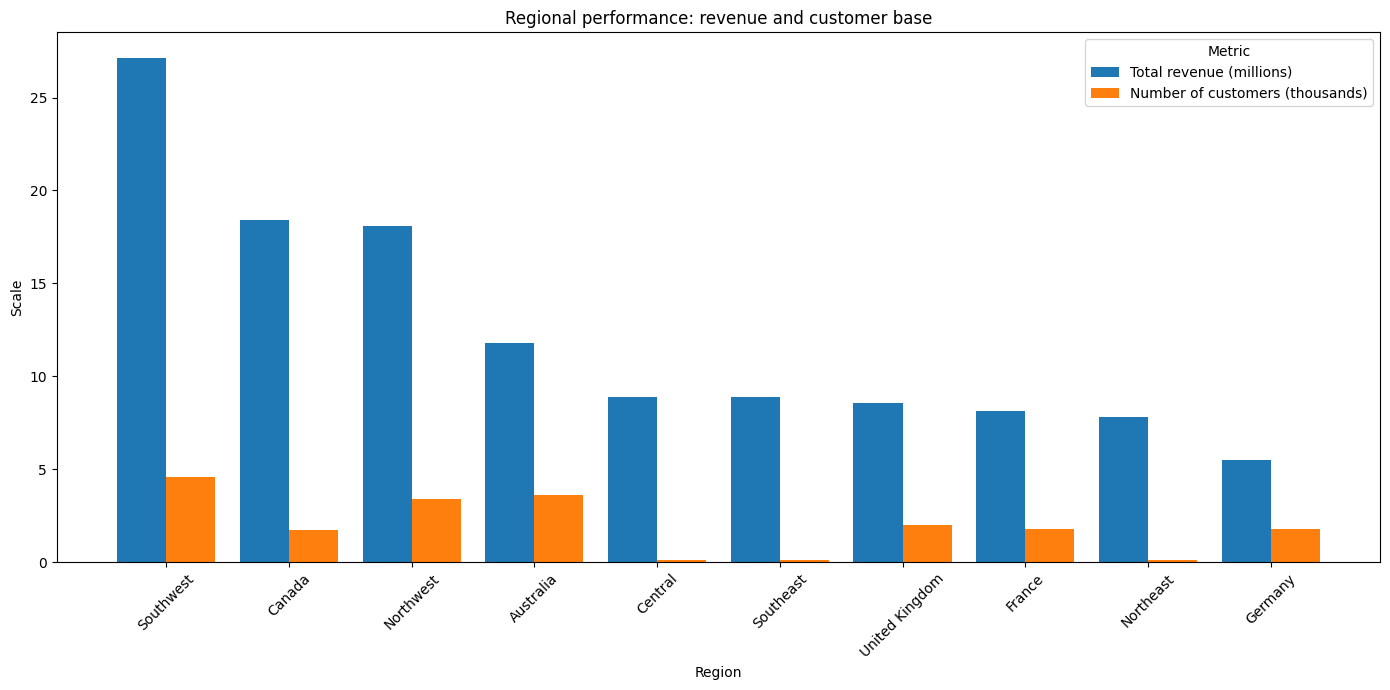

Note: sales are scaled to millions, customers are scaled to thousands for visual comparison.


In [18]:
df06_plot = df06.sort_values("TotalSales", ascending=False).copy()
df06_plot["Sales ($M)"] = (df06_plot["TotalSales"] / 1e6).round(2)
df06_plot["Customers (1k)"] = (df06_plot["UniqueCustomers"] / 1e3).round(1)

grouped_bar_wide(
    df06_plot,
    x="Region",
    y_cols=["Sales ($M)", "Customers (1k)"],
    y_col_labels=[
        "Total revenue (millions)",
        "Number of customers (thousands)"
    ],
    title="Regional performance: revenue and customer base",
    ylabel="Scale",
    legend_title="Metric",
    rotate_x=45,
    figsize=(14, 7)
)

print("Note: sales are scaled to millions, customers are scaled to thousands for visual comparison.")

This visualization compares total revenue and the number of unique customers across regions. Some regions generate high total sales primarily through a large customer base, while others achieve similar revenue levels with fewer customers. This reveals differences in customer value between regions and suggests that regional strategies should differ, focusing on volume growth in some markets and value optimization in others.

In [19]:
strongest = df06.iloc[0]
weakest = df06.iloc[-1]
highest_spc = df06.loc[df06["SalesPerCustomer"].idxmax()]
lowest_spc = df06.loc[df06["SalesPerCustomer"].idxmin()]

print(f"""
TOP PERFORMANCE:
- Lead Region:   {strongest['Region']}
  Performance:   {strongest['TotalSales']/1e6:.2f}M in sales
  Reach:         {strongest['UniqueCustomers']/1e3:.1f}K unique customers

LOWEST PERFORMANCE:
- Trail Region:  {weakest['Region']}
  Performance:   {weakest['TotalSales']/1e6:.2f}M in sales
  Reach:         {weakest['UniqueCustomers']/1e3:.1f}K unique customers

CUSTOMER VALUE (Sales per Customer):
- Highest Value: {highest_spc['Region']} (${highest_spc['SalesPerCustomer']:,.0f} per customer)
- Lowest Value:  {lowest_spc['Region']} (${lowest_spc['SalesPerCustomer']:,.0f} per customer)

STRATEGIC NOTE:
Regions with high revenue but lower customer counts (like {highest_spc['Region']}) suggest high-value transactions.
Regions with high customer counts but  lower sales per customer indicate a need for upselling or larger baskets.
""")


TOP PERFORMANCE:
- Lead Region:   Southwest
  Performance:   27.15M in sales
  Reach:         4.6K unique customers

LOWEST PERFORMANCE:
- Trail Region:  Germany
  Performance:   5.48M in sales
  Reach:         1.8K unique customers

CUSTOMER VALUE (Sales per Customer):
- Highest Value: Northeast ($137,197 per customer)
- Lowest Value:  Germany ($3,024 per customer)

STRATEGIC NOTE:
Regions with high revenue but lower customer counts (like Northeast) suggest high-value transactions.
Regions with high customer counts but  lower sales per customer indicate a need for upselling or larger baskets.



## 7) Which regions have the highest/lowest average order value, and does it differ between individuals and stores?

**Method:** Identify customer type via `Sales.Customer.StoreID` (Store vs Individual) and compute AOV = total sales / number of orders.

In [34]:
sql_07 = """
WITH Orders AS (
    SELECT
        st.Name AS Region,
        CASE WHEN c.StoreID IS NULL THEN 'Individual' ELSE 'Store' END AS CustomerType,
        soh.SalesOrderID,
        soh.TotalDue
    FROM Sales.SalesOrderHeader soh
    JOIN Sales.SalesTerritory st
        ON st.TerritoryID = soh.TerritoryID
    JOIN Sales.Customer c
        ON c.CustomerID = soh.CustomerID
)
SELECT
    Region,
    CustomerType,
    SUM(TotalDue) AS TotalSales,
    COUNT(DISTINCT SalesOrderID) AS OrderCount,
    SUM(TotalDue) * 1.0 / COUNT(DISTINCT SalesOrderID) AS AvgOrderValue
FROM Orders
GROUP BY Region, CustomerType;
"""

df07 = read_sql(sql_07)
df07["AvgOrderValue"] = df07["AvgOrderValue"].round(2)

region_avg = (
    df07.groupby("Region")[["TotalSales", "OrderCount"]]
    .sum()
    .assign(OverallAvgOrderValue=lambda x: x["TotalSales"] / x["OrderCount"])
    ["OverallAvgOrderValue"]
)

In [35]:
pivot_aov = (
    df07
    .pivot(index="Region", columns="CustomerType", values="AvgOrderValue")
    .fillna(0)
    .join(region_avg)
    .sort_values("OverallAvgOrderValue", ascending=False)
    .drop(columns="OverallAvgOrderValue")
    .round(2)
)
pivot_aov


,Individual,Store
Region,,
Central,368.44,23696.76
Northeast,721.84,22845.00
Southeast,795.53,18913.81
Canada,647.56,23429.78
Southwest,1154.50,27739.06
Northwest,993.86,26172.68
France,1176.18,27649.52
United Kingdom,1236.50,25671.31
Germany,1287.53,16414.42


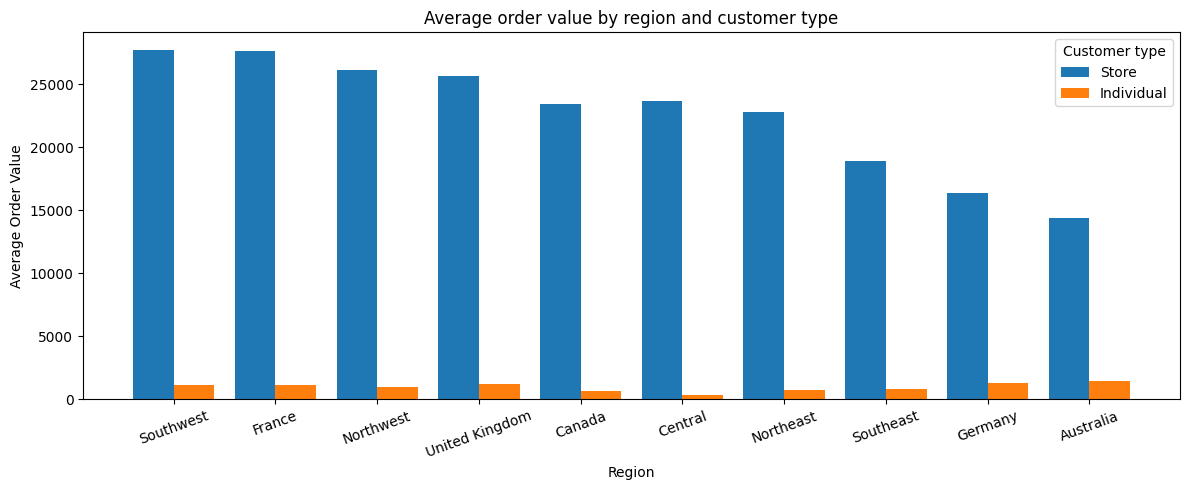

In [22]:
grouped_bar_wide(
    pivot_aov.reset_index(),
    x="Region",
    y_cols=["Store", "Individual"],
    title="Average order value by region and customer type",
    ylabel="Average Order Value",
    legend_title="Customer type",
    rotate_x=20,
    figsize=(12, 5),
)

This grouped bar chart compares average order value across regions, split between store (business) and individual (consumer) customers.

Across all regions, Store customers consistently have a significantly higher average order value than Individual customers. This confirms that business customers place larger, higher-value orders, likely due to bulk purchasing, contractual agreements, or resale activity.

The size of this gap varies notably by region. Regions such as Southwest, France, and Northwest show the highest average order values for Store customers, indicating strong business-to-business sales performance in these markets. In contrast, regions like Australia and Germany show lower average order values overall, particularly for Store customers, suggesting smaller deal sizes or less developed B2B demand.

The highest average order value is observed for Store customers in the Southwest region, making this region–customer-type combination the strongest in terms of transaction value.

These regional differences may be explained by variations in market maturity, presence of large corporate customers, regional pricing strategies, or differences in product mix sold to business versus individual customers.

# Deep dive: product portfolio analysis (option B)

The purpose of this deep dive is to evaluate the product portfolio by combining revenue and profitability measures in order to distinguish between high-performing and underperforming products. Products are classified as **“winners”** when they generate both strong revenue and healthy profit margins, and as **“losers”** when they exhibit low revenue and/or weak profitability.

Because detailed cost data is not available in the dataset, `StandardCost` from `Production.Product` is used as a consistent proxy for product cost.

The following metrics are applied throughout the analysis:
- **Revenue:** total sales value calculated as UnitPrice × OrderQty × (1 − UnitPriceDiscount)
- **Estimated profit:** (UnitPrice × (1 − UnitPriceDiscount) − StandardCost) × OrderQty
- **Profit margin (%):** estimated profit divided by revenue


In [37]:
sql_b1 = """
SELECT
    pc.Name AS Category,
    p.Name AS ProductName,
    SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) AS Revenue,
    SUM((sod.UnitPrice * (1 - sod.UnitPriceDiscount) - p.StandardCost) * sod.OrderQty) AS Profit
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON p.ProductID = sod.ProductID
JOIN Production.ProductSubcategory psc
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Production.ProductCategory pc
    ON pc.ProductCategoryID = psc.ProductCategoryID
GROUP BY pc.Name, p.Name
HAVING SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) > 0
"""

df_b1 = read_sql(sql_b1)
df_b1["MarginPct"] = (
    df_b1["Profit"] / df_b1["Revenue"]
).replace([float("inf"), -float("inf")], 0) * 100
df_b1["MarginPct"] = df_b1["MarginPct"].round(2)
df_b1.head()


,Category,ProductName,Revenue,Profit,MarginPct
0,Bikes,"Road-250 Red, 44",1.448122e+06,88808.6504,6.13
1,Accessories,Bike Wash - Dissolver,1.840697e+04,8538.6056,46.39
2,Components,LL Mountain Handlebars,2.200827e+04,4902.2017,22.27
3,Bikes,"Mountain-200 Black, 46",3.309673e+06,666740.6930,20.15
4,Bikes,"Mountain-200 Black, 42",4.009495e+06,674216.5796,16.82


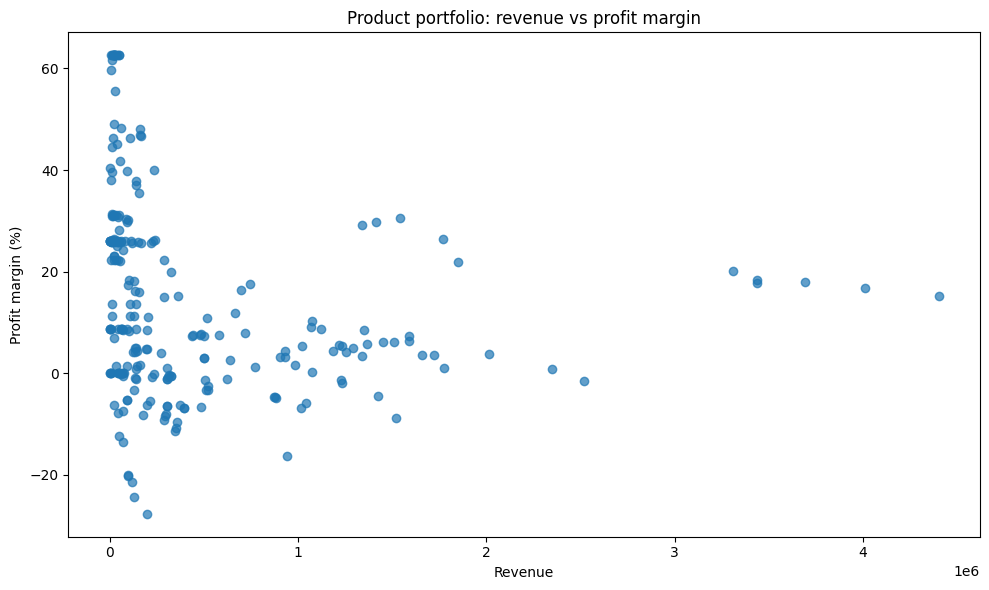

In [38]:
scatter_plot(
    df_b1,
    x="Revenue",
    y="MarginPct",
    title="Product portfolio: revenue vs profit margin",
    xlabel="Revenue",
    ylabel="Profit margin (%)"
)

This visualization plots products based on their total revenue and profit margin, using standard cost as a proxy for profitability. Each point represents an individual product.

The chart shows that high revenue does not always correspond to high margins. Some products generate large sales volumes but contribute relatively little to profitability, while others deliver strong margins despite lower revenue. This distinction helps identify both “winners” to prioritize and “risk” products that require pricing or cost review.

This scatter plot divides the product portfolio into four natural quadrants:
- Top-right: high revenue & high margin → winners
- Bottom-left: low revenue & low/negative margin → losers
- High revenue, low margin: volume drivers with pricing pressure
- Low revenue, high margin: niche or premium products

In [39]:
rev_median = df_b1["Revenue"].median()
margin_median = df_b1["MarginPct"].median()

df_b1["PortfolioGroup"] = "Neutral"
df_b1.loc[
    (df_b1["Revenue"] >= rev_median) & (df_b1["MarginPct"] >= margin_median),
    "PortfolioGroup"
] = "Winner"

df_b1.loc[
    (df_b1["Revenue"] < rev_median) & (df_b1["MarginPct"] < 0),
    "PortfolioGroup"
] = "Loser"

df_b1["PortfolioGroup"].value_counts()

PortfolioGroup
Neutral    216
Winner      38
Loser       12
Name: count, dtype: int64

In [40]:
sql_b2 = """
SELECT
    p.Name AS ProductName,
    SUM(sod.OrderQty) AS TotalQuantity,
    SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) AS Revenue
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON p.ProductID = sod.ProductID
GROUP BY p.Name
"""

df_qty = read_sql(sql_b2)
df_qty.head()

,ProductName,TotalQuantity,Revenue
0,All-Purpose Bike Stand,249,39591.0000
1,AWC Logo Cap,8311,51229.4461
2,Bike Wash - Dissolver,3319,18406.9725
3,Cable Lock,1087,16240.2200
4,Chain,774,9377.7102


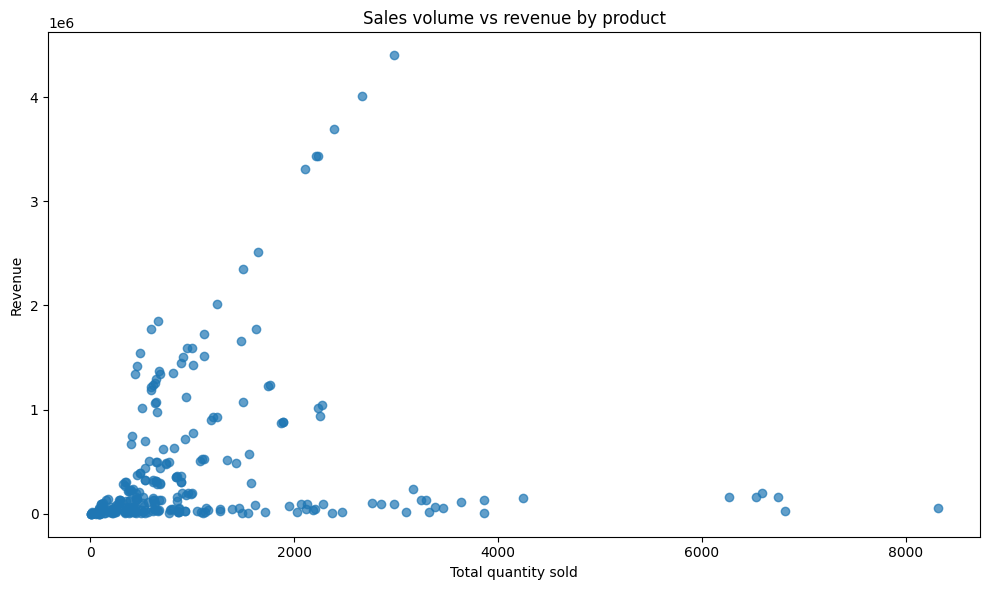

In [41]:
scatter_plot(
    df_qty,
    x="TotalQuantity",
    y="Revenue",
    title="Sales volume vs revenue by product",
    xlabel="Total quantity sold",
    ylabel="Revenue"
)

This visualization reveals products that sell in high volumes but generate relatively low revenue.
Such products may suffer from:
- Heavy discounting
- Low unit prices
- Inefficient product positioning

These products are candidates for price optimization or cost reduction rather than volume expansion.

In [43]:
sql_b3 = """
SELECT
    pc.Name AS Category,
    SUM(sod.UnitPrice * sod.OrderQty * (1 - sod.UnitPriceDiscount)) AS Revenue,
    SUM((sod.UnitPrice * (1 - sod.UnitPriceDiscount) - p.StandardCost) * sod.OrderQty) AS Profit
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p
    ON p.ProductID = sod.ProductID
JOIN Production.ProductSubcategory psc
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Production.ProductCategory pc
    ON pc.ProductCategoryID = psc.ProductCategoryID
GROUP BY pc.Name
"""

df_cat = read_sql(sql_b3)
df_cat["MarginPct"] = (df_cat["Profit"] / df_cat["Revenue"]) * 100
df_cat = df_cat.round(2)
df_cat


,Category,Revenue,Profit,MarginPct
0,Accessories,1272072.89,636394.28,50.03
1,Bikes,94651172.72,7936394.06,8.38
2,Clothing,2120542.53,308882.27,14.57
3,Components,11802593.29,490233.17,4.15


In [44]:
pivot_cat = df_b1.pivot_table(
    index="Category",
    values=["Revenue", "Profit", "MarginPct"],
    aggfunc="mean"
).round(2)

pivot_cat

,MarginPct,Profit,Revenue
Category,,,
Accessories,55.34,26516.43,53003.04
Bikes,6.07,81818.50,975785.29
Clothing,24.31,9084.77,62368.90
Components,12.51,4416.52,106329.67


The pivot table highlights structural differences between categories, showing which product groups consistently achieve higher margins and which rely more heavily on volume.

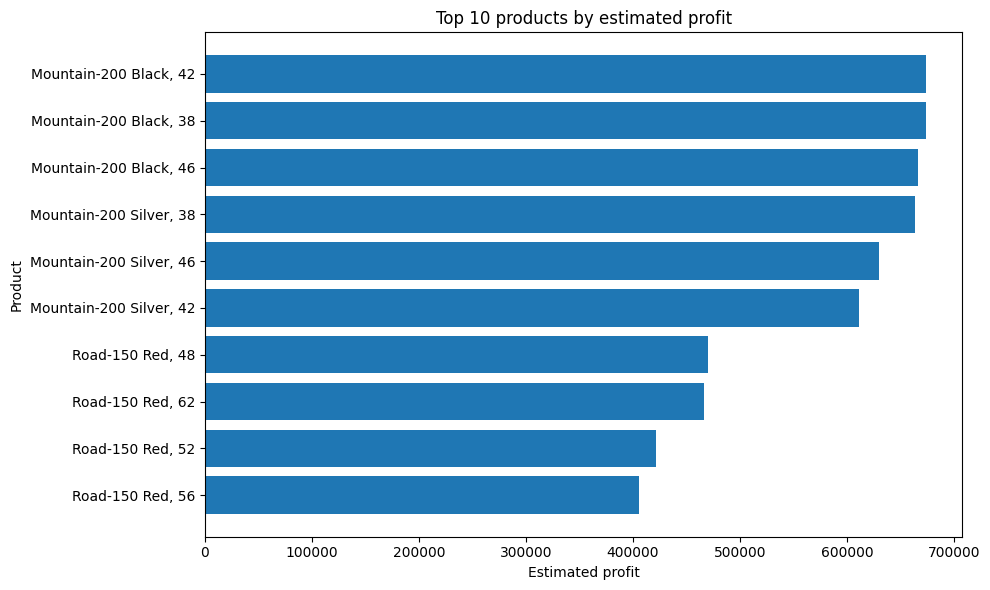

Most profitable product (proxy): Mountain-200 Black, 42 (674,217)


In [45]:
top_profit = df_b1.sort_values("Profit", ascending=False).head(10)

bar_horizontal(
    top_profit,
    x="Profit",
    y="ProductName",
    title="Top 10 products by estimated profit",
    xlabel="Estimated profit",
    ylabel="Product"
)

print(
    f"Most profitable product (proxy): "
    f"{top_profit.iloc[0]['ProductName']} "
    f"({top_profit.iloc[0]['Profit']:,.0f})"
)

# Reflection – product portfolio analysis (option B)

### Why did you choose this deep dive? What did you want to investigate?
I chose a product portfolio analysis to understand which products actually create value for the business, not just high sales volume. The goal was to identify winners (high revenue and strong margins), losers (low revenue or negative margins), and products with high quantity but low revenue, which may indicate pricing or cost issues.

### Why did you choose aggregation in SQL vs pandas?

I performed the main aggregations in SQL to:
- Ensure calculations are done close to the source data
- Correctly join multiple tables and calculate revenue and profit
- Reduce the dataset size before loading it into Python

Pandas was then used for further analysis, pivot tables, and visualizations, where it is more flexible.

### Why did you choose these types of charts?

- Scatter plot (revenue vs profit margin) was chosen to clearly separate winners and losers.
- Bar charts were used to compare top products and categories in terms of profit and revenue.
- These visualizations make it easy to interpret performance at both product and category level.

### How did pivot tables help you identify patterns in the data?

Pivot tables helped summarize large amounts of data and revealed clear patterns, such as:
- Accessories having high average margins but lower total revenue
- Bikes dominating total revenue but with significantly lower margins
This made category-level trade-offs easy to identify.

### What concrete recommendations does your deep dive provide?

- Focus investment on high-margin, high-revenue products such as Mountain-200 models.
- Review pricing or cost structure for low-margin bike products like Road-250 variants.
- Consider expanding Accessories, which show strong margins despite lower revenue.
- Re-evaluate products with high quantity but low revenue (e.g. AWC Logo Cap), as they may be underpriced.

# Summary

### Key findings
- A small number of products generate most of the profit.
- Bikes drive revenue, but Accessories drive margin.
- Several high-volume products contribute little to profitability.

### Recommendations
- Prioritize winners for growth and marketing.
- Improve pricing or cost efficiency for low-margin products.
- Consider discontinuing or redesigning consistent losers.
- Use this analysis to guide a more profitable product strategy.